# Water Quality Classification Analysis

# Imports

In [68]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# Models 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from xgboost import XGBClassifier

# Data Processing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, make_scorer, f1_score, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, GridSearchCV
from sklearn.decomposition import PCA


# Model Processing
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, StandardScaler
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN

# K Best columns
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif

# Functions

In [83]:
def check_for_dupes_nans(df:pd.DataFrame):
    """
    Checks for dupes and nulls
    """
    amount_of_dupes = df.duplicated().sum()
    print(f"Null Count: {df.isna().sum()}")
    print(f"Dupe Count: {amount_of_dupes}")

def check_class_imbalance(df:pd.DataFrame, target:pd.Series, col:str):
  counter = Counter(target)
  for k,v in counter.items():
    per = v/len(target) * 100
    print("Class=%s, Count=%d, Percentage=%.3f%%" % (k,v, per))
  
  ax = df[col].value_counts().sort_index().plot(
  kind="bar", 
  title="Count of Reviews by Target", 
  figsize=(10,5)
  )
  ax.set_xlabel(col)
  plt.show()

def create_pipeline(preprocessor, features):
  return preprocessor.fit_transform(features)

def evaluate_model(X:pd.Series, y:pd.Series, model):
    """
    This function takes in X, y values
    scores model performance based on
    subsets of data

    Returns:
        scores of models
    """
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    
    metric = make_scorer(f1_score)
    scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
    return scores

def testing_selected_models(names:list, models:list, X:pd.DataFrame, y:pd.Series):
    """
    Runs multiple subsets on folds of data

    Args:
        names (list): _description_
        models (list): _description_
    """
    
    model_performance = []
    for i in range(len(models)):
        model = models[i]
        scores = evaluate_model(X, y, model)
        model_performance.append({
            "Model": names[i],
            "Mean": np.mean(scores),
            "STD":np.std(scores)
        })
    performance_df = pd.DataFrame(model_performance)
    return performance_df.sort_values(by="Mean", ascending=False)
  
def get_selected_models(names):
  """
  Returns selected models for ML processing

  Args:
      names (_type_):List

  Returns:
      List of models
  """
  models = {
    "LDA": LinearDiscriminantAnalysis(),
    "GPC": GaussianProcessClassifier(),
    "GNB": GaussianNB(),
    "SVC": SVC(),
    "LR":LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "DTC": DecisionTreeClassifier(),
    "GBC":GradientBoostingClassifier(),
    "RFC":RandomForestClassifier(),
    "XGB": XGBClassifier(),
    "MN": MultinomialNB()
  }
  
  return [models[model] for model in names]

def get_over_sampling_methods(X, y, name):
  
  sampling_models = {
    "KNN-SMOTE":SMOTE(k_neighbors=5, random_state=42),
    "BL-SMOTE": BorderlineSMOTE(kind='borderline-1', random_state=42),
    "SMOTE": SMOTE(),
    "ADASYN": ADASYN(random_state=42)
  }
  
  sampling_model = sampling_models[name]
  X_res, y_res = sampling_model.fit_resample(X, y)
  
  return (X_res, y_res)

def create_confusion_matrix(model_name:str, y_test:pd.Series, y_test_pred:pd.Series):
    """
    This function displays a classificaiton report
    & a Confusion Matrix

    Args:
        model_name (str): _description_
        y_test (pd.Series): _description_
        y_test_pred (pd.Series): _description_
    """
    
    cr = classification_report(y_test, y_test_pred)
    print(cr)
    conf_mat = confusion_matrix(y_test,y_test_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix {model_name}')
    plt.show()

def val_grid_search_selected_models(names:list, models:list, X:pd.DataFrame, 
    y:pd.Series, metric, param_grid=None, kbest=None, kbest_name=None):
    """
    Runs multiple models on subsets of data
    using grid search
    - Grabs best Validation score
    - Grabs best accuracy score
    - Grabs best model Params
    """
    
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    model_performance = []

    for i in range(len(models)):
        pipeline, name = models[i], names[i]
    
        if param_grid:
            grid_search = GridSearchCV(pipeline, param_grid[name], cv=5, scoring=metric, n_jobs=-1)
            grid_search.fit(X_train, y_train)
            best_model = grid_search.best_estimator_
            
            print(f'Best score for {name}: {grid_search.best_score_:.3f}')
            print("Best parameters:", grid_search.best_params_)
        
        else:
            best_model = pipeline
            best_model.fit(X_train, y_train)
        
        y_pred = best_model.predict(X_val)
        y_test_pred = best_model.predict(X_test)
            
        val_accuracy = accuracy_score(y_val, y_pred)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        
        print(f'Validation Test accuracy for {name}: {val_accuracy:.3f}')
        print(f'Test accuracy for {name}: {test_accuracy:.3f}')
        print("---------------------------------------------------------------")
        create_confusion_matrix(name, y_test, y_test_pred)
            
        model_performance.append({
                "Model": name,
                "Validation Accuracy": val_accuracy,
                "Test Accuracy": test_accuracy,
        })
    return pd.DataFrame(model_performance).sort_values(by="Test Accuracy", ascending=False)

def pca_analysis(X):
  
    features = X.shape[1]
    results = []
    for n_components in range(1, features + 1):
        pca = PCA(n_components=n_components)
        
        X_pca = pca.fit_transform(X)
        
        explained_variance = np.sum(pca.explained_variance_ratio_)
        
        results.append({
            'Number of Components': n_components,
            'Cumulative Explained Variance': explained_variance
        })
    results_df = pd.DataFrame(results)
    return results_df

# EDA Analysis

In [3]:
df = pd.read_csv("/Users/maukanmir/Downloads/water.csv")
df

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
...,...,...,...,...,...,...,...,...,...,...
3271,4.668102,193.681735,47580.991603,7.166639,359.948574,526.424171,13.894419,66.687695,4.435821,1
3272,7.808856,193.553212,17329.802160,8.061362,NaN,392.449580,19.903225,NaN,2.798243,1
3273,9.419510,175.762646,33155.578218,7.350233,NaN,432.044783,11.039070,69.845400,3.298875,1
3274,5.126763,230.603758,11983.869376,6.303357,NaN,402.883113,11.168946,77.488213,4.708658,1


# Check For Nulls and Dupes

In [4]:
check_for_dupes_nans(df)

Null Count: ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64
Dupe Count: 0


# We will have to fill Null values with either the mean or the median depending on the distribution

# Check For Class Imbalance

Class=0, Count=1998, Percentage=60.989%
Class=1, Count=1278, Percentage=39.011%


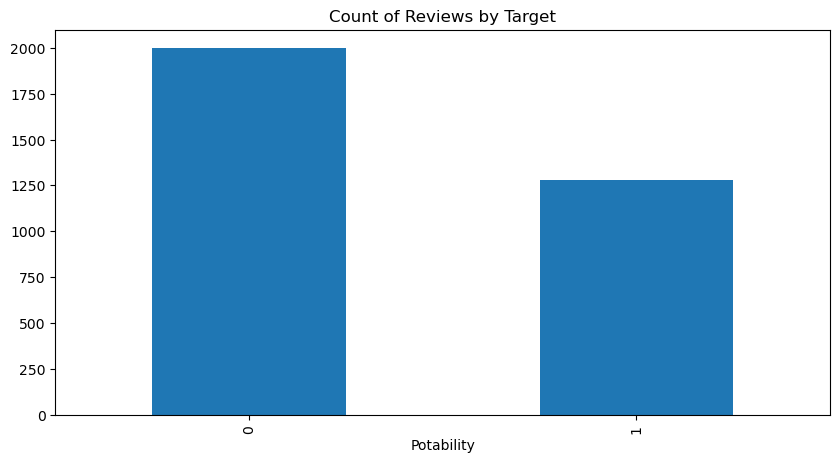

In [5]:
check_class_imbalance(df,df['Potability'], 'Potability')

# Somewhat imbalanced dataset, we might need to use sampling methods. We will have to check.

In [6]:
df.dtypes

ph                 float64
Hardness           float64
Solids             float64
Chloramines        float64
Sulfate            float64
Conductivity       float64
Organic_carbon     float64
Trihalomethanes    float64
Turbidity          float64
Potability           int64
dtype: object

In [7]:
df.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690297,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762127,8.114887,359.950170,481.792304,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


# PH Column is normally distributed given the std but lets plot this and see for ourselves

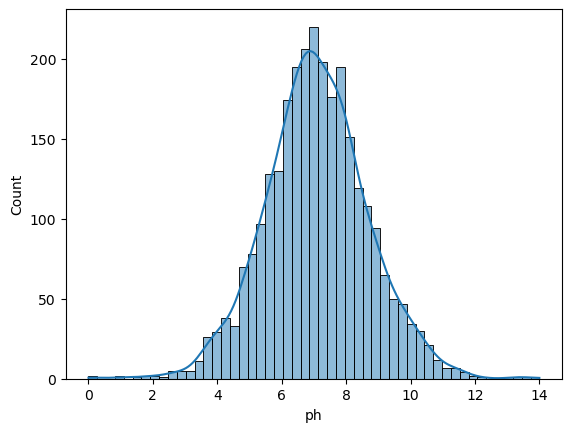

In [8]:
sns.histplot(df['ph'], kde=True)
plt.show()

# Sulfate seems skewed, lets see.

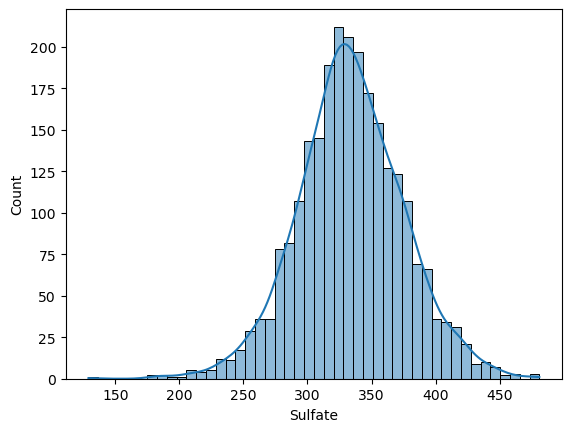

Skewness: -0.03594662160705805


In [11]:
sns.histplot(df['Sulfate'], kde=True)
plt.show()

skewness = df['Sulfate'].skew()
print(f"Skewness: {skewness}")

# Slightly negative skew for Trihalomethanes

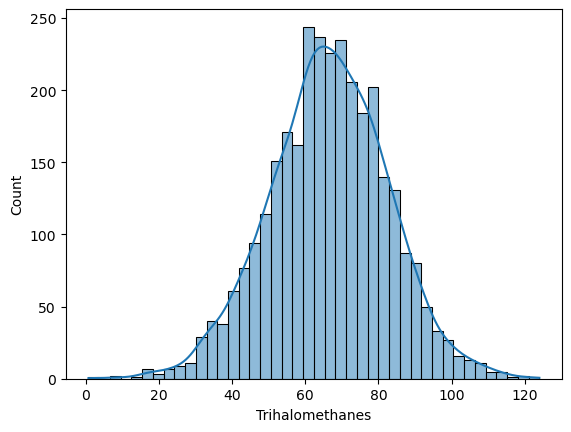

Skewness: -0.08303067407901556


In [12]:
sns.histplot(df['Trihalomethanes'], kde=True)
plt.show()

skewness = df['Trihalomethanes'].skew()
print(f"Skewness: {skewness}")

# Give the skew is negative but minimal, the mean would be a good choice here to use to fill in null values

# Separate Feature Variables

In [16]:
X,y = df.drop("Potability", axis=1), df["Potability"]

# Create Preprocessor

In [48]:
preprocessor = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ("power_transformer", PowerTransformer())
])

X = create_pipeline(preprocessor, X)

# Baseline Model

In [49]:
model = DummyClassifier(strategy="uniform")
scores = evaluate_model(X, y, model)
print(f"Mean: {round(np.mean(scores),3)}, STD: {round(np.std(scores),3)}")

Mean: 0.438, STD: 0.021


# Advanced Model Metrics

In [50]:
names = ['LR', 'SVC']
models = get_selected_models(names)
testing_selected_models(names, models, X, y)

,Model,Mean,STD
1,SVC,0.418838,0.026830
0,LR,0.003107,0.004742


In [51]:
names = ["RFC", "DTC", "GBC", "XGB"]
models = get_selected_models(names)
testing_selected_models(names, models, X, y)

,Model,Mean,STD
1,DTC,0.477809,0.023535
3,XGB,0.469307,0.020640
0,RFC,0.445506,0.026639
2,GBC,0.358639,0.025134


# We may need to test sampling methods as the model is performing poorly

# SMOTE Method

In [54]:
X_smote, y_smote = get_over_sampling_methods(X, y, "SMOTE")

In [55]:
names = ['LR', 'SVC']
models = get_selected_models(names)
testing_selected_models(names, models, X_smote, y_smote)

,Model,Mean,STD
1,SVC,0.667713,0.017758
0,LR,0.511814,0.016803


In [56]:
names = ["RFC", "DTC", "GBC", "XGB"]
models = get_selected_models(names)
testing_selected_models(names, models, X_smote, y_smote)

,Model,Mean,STD
0,RFC,0.730566,0.016339
3,XGB,0.688184,0.012683
1,DTC,0.640915,0.013974
2,GBC,0.632642,0.017032


# Borderline Smote

In [57]:
X_bl, y_bl = get_over_sampling_methods(X, y, "BL-SMOTE")

In [60]:
names = ['LR', 'SVC', 'LDA', 'GPC', 'GNB']
models = get_selected_models(names)
testing_selected_models(names, models, X_bl, y_bl)

,Model,Mean,STD
3,GPC,0.733286,0.015474
1,SVC,0.689140,0.011591
4,GNB,0.557839,0.019415
0,LR,0.495485,0.010637
2,LDA,0.495443,0.010575


In [59]:
names = ["RFC", "DTC", "GBC", "XGB"]
models = get_selected_models(names)
testing_selected_models(names, models, X_bl, y_bl)

,Model,Mean,STD
0,RFC,0.738055,0.013548
3,XGB,0.691667,0.012986
1,DTC,0.640952,0.015068
2,GBC,0.639869,0.010834


# ADASYN

In [61]:
X_ada, y_ada = get_over_sampling_methods(X, y, "ADASYN")

In [62]:
names = ['LR', 'SVC', 'LDA', 'GPC', 'GNB']
models = get_selected_models(names)
testing_selected_models(names, models, X_ada, y_ada)

,Model,Mean,STD
3,GPC,0.730730,0.009850
1,SVC,0.675935,0.011418
4,GNB,0.561373,0.024450
2,LDA,0.535911,0.022053
0,LR,0.535870,0.022077


In [63]:
names = ["RFC", "DTC", "GBC", "XGB"]
models = get_selected_models(names)
testing_selected_models(names, models, X_ada, y_ada)

,Model,Mean,STD
0,RFC,0.734972,0.009159
3,XGB,0.681884,0.014962
2,GBC,0.647451,0.009921
1,DTC,0.636302,0.013469


# KNN-SMOTE

In [64]:
X_knn, y_knn = get_over_sampling_methods(X, y, "KNN-SMOTE")

In [65]:
names = ['LR', 'SVC', 'LDA', 'GPC', 'GNB']
models = get_selected_models(names)
testing_selected_models(names, models, X_knn, y_knn)

/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


,Model,Mean,STD
3,GPC,0.718742,0.015153
1,SVC,0.667964,0.017265
0,LR,0.504004,0.015066
2,LDA,0.503831,0.015385
4,GNB,0.502566,0.017437


In [66]:
names = ["RFC", "DTC", "GBC", "XGB"]
models = get_selected_models(names)
testing_selected_models(names, models, X_knn, y_knn)

,Model,Mean,STD
0,RFC,0.732303,0.016641
3,XGB,0.686217,0.014027
1,DTC,0.634172,0.020680
2,GBC,0.629279,0.017025


# We see large improvements with over sampling, lets add this in with hyper parameter tuning

# Remove variables from memory

In [67]:
variables_to_delete = [X_knn, y_knn, X_smote, y_smote, X_ada, y_ada]

for variable in variables_to_delete:
  del variable

# Hyper parameter tunning

Best score for LR: 0.499
Best parameters: {'C': 0.2, 'solver': 'newton-cg'}
Validation Test accuracy for LR: 0.457
Test accuracy for LR: 0.512
---------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.53      0.54      0.54       313
           1       0.49      0.48      0.48       287

    accuracy                           0.51       600
   macro avg       0.51      0.51      0.51       600
weighted avg       0.51      0.51      0.51       600



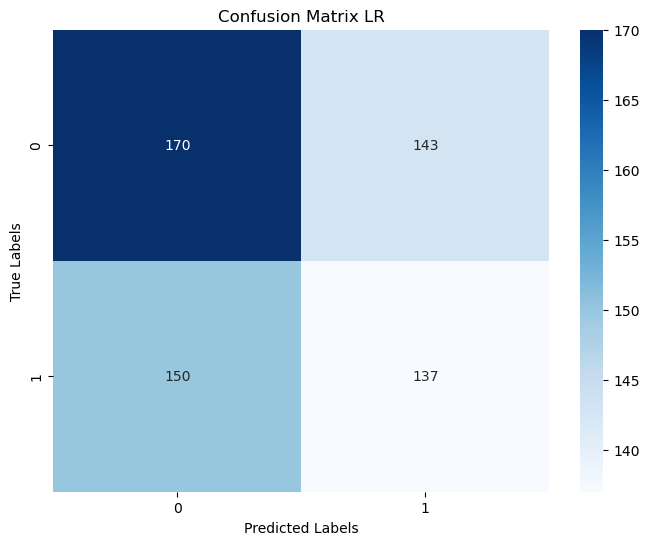

Best score for SVC: 0.655
Best parameters: {'C': 1, 'kernel': 'rbf'}
Validation Test accuracy for SVC: 0.644
Test accuracy for SVC: 0.657
---------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.70      0.59      0.64       313
           1       0.62      0.73      0.67       287

    accuracy                           0.66       600
   macro avg       0.66      0.66      0.66       600
weighted avg       0.66      0.66      0.66       600



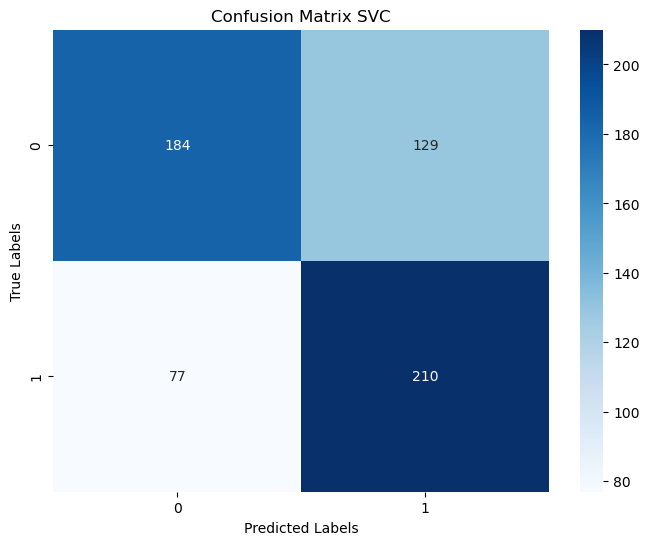

,Model,Validation Accuracy,Test Accuracy
1,SVC,0.644407,0.656667
0,LR,0.457429,0.511667


In [71]:
param_grid = {
  "LR":{
        'solver': ['newton-cg', 'sag', 'saga', 'lbfgs'],
        'C': [0.1, 0.2, 0.4, 0.5, 1, 2, 4, 5, 10, 20, 50, 100, 400]
  },
  "SVC": {
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'C': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
  }
    }

names = ["LR", "SVC"]
models = get_selected_models(names)
metric = make_scorer(accuracy_score)
val_grid_search_selected_models(names, models, X_bl, y_bl, metric , param_grid)

Best score for RFC: 0.710
Best parameters: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Validation Test accuracy for RFC: 0.699
Test accuracy for RFC: 0.728
---------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.74      0.75      0.74       313
           1       0.72      0.71      0.71       287

    accuracy                           0.73       600
   macro avg       0.73      0.73      0.73       600
weighted avg       0.73      0.73      0.73       600



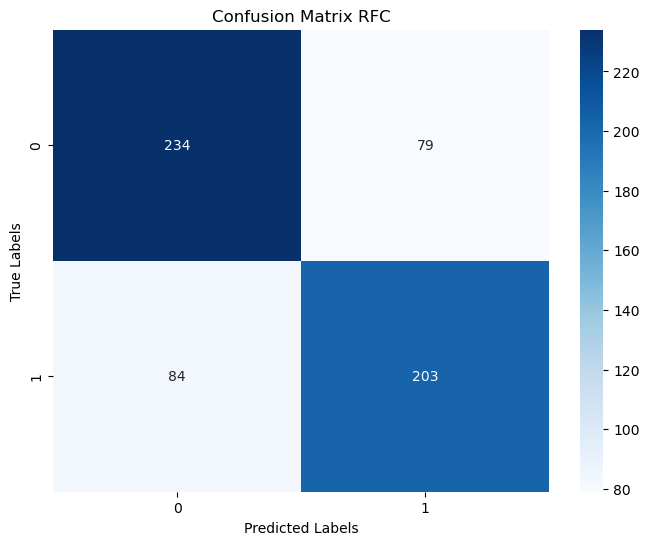

Best score for GBC: 0.678
Best parameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300}
Validation Test accuracy for GBC: 0.664
Test accuracy for GBC: 0.695
---------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.72      0.69      0.70       313
           1       0.67      0.70      0.69       287

    accuracy                           0.69       600
   macro avg       0.69      0.70      0.69       600
weighted avg       0.70      0.69      0.70       600



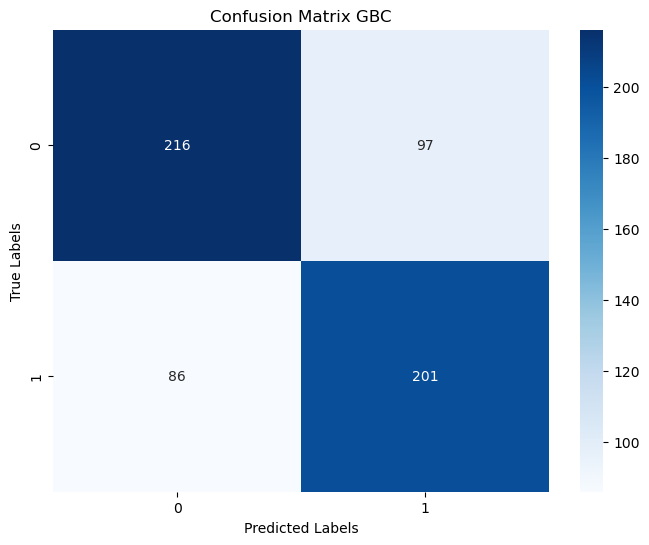

Best score for XGB: 0.677
Best parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300}
Validation Test accuracy for XGB: 0.668
Test accuracy for XGB: 0.690
---------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.70      0.70      0.70       313
           1       0.67      0.68      0.68       287

    accuracy                           0.69       600
   macro avg       0.69      0.69      0.69       600
weighted avg       0.69      0.69      0.69       600



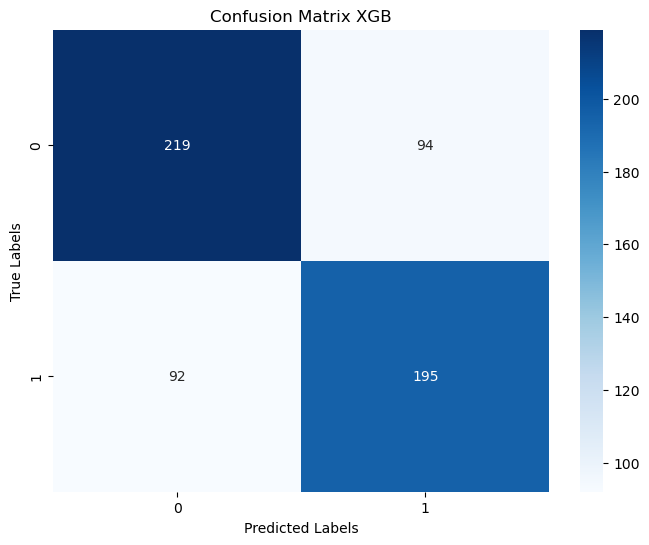

,Model,Validation Accuracy,Test Accuracy
0,RFC,0.699499,0.728333
1,GBC,0.664441,0.695000
2,XGB,0.667780,0.690000


In [74]:
param_grid = {
  "RFC":{
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
  },
  "GBC": {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
  },
  'XGB': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2]
    }
    }

names = ["RFC", "GBC", "XGB"]
models = get_selected_models(names)
metric = make_scorer(accuracy_score)
val_grid_search_selected_models(names, models, X_bl, y_bl, metric , param_grid)

# Best model: RFC -> Best parameters: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}

Validation Test accuracy for RFC: 0.703
Test accuracy for RFC: 0.730
---------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.74      0.74      0.74       313
           1       0.72      0.72      0.72       287

    accuracy                           0.73       600
   macro avg       0.73      0.73      0.73       600
weighted avg       0.73      0.73      0.73       600



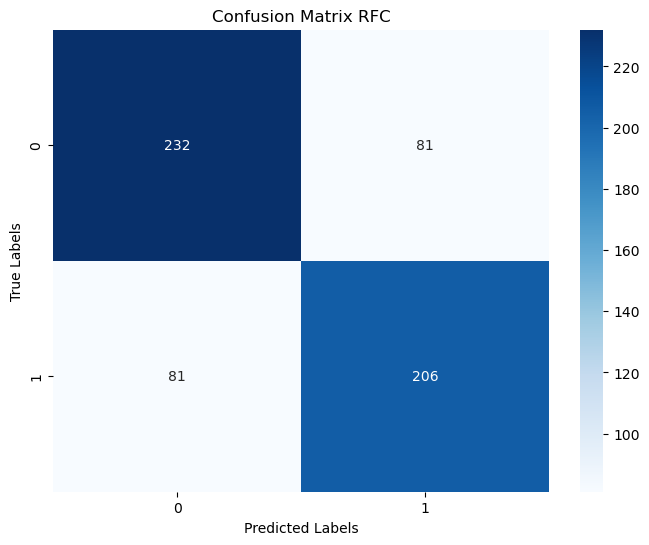

,Model,Validation Accuracy,Test Accuracy
0,RFC,0.702838,0.73


In [75]:
names = ["RFC"]
models = [
  RandomForestClassifier(max_depth=30, min_samples_leaf=1, min_samples_split=5, n_estimators=300)
]
metric = make_scorer(accuracy_score)
val_grid_search_selected_models(names, models, X_bl, y_bl, metric)

# PCA Analysis

In [79]:
pca_analysis(X_bl)

,Number of Components,Cumulative Explained Variance
0,1,0.131169
1,2,0.256340
2,3,0.375067
3,4,0.493218
4,5,0.605105
5,6,0.712565
6,7,0.817956
7,8,0.915264
8,9,1.000000


# 6 - 9 Columns hold 70-90% of the variance